<a href="https://colab.research.google.com/github/giacomoarienti/data-intensive-lab/blob/master/BBS_TextMining_Lab4_Finetuning_Prompting_LLMs_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Text Summarization: Fine-tuning and Prompting with Small & Large Language Models

**Text Mining unit**

_Prof. Gianluca Moro, Dott. Luca Ragazzi, Dott. Lorenzo Molfetta – DISI, University of Bologna_

Alma Mater Studiorum Università di Bologna

## 📜 Outline

- [ 0 - Setup Kernel and Required Dependencies](#0)
- [ 1 - Brief Introduction on Automatic Text Summarization](#1)
    - [ 1.1 - Extractive Summarization](#1.1)
    - [ 1.2 - Abstractive Summarization](#1.2)
- [ 2 - Understand How Language Models Work](#2)
    - [ 2.1 - Load the Model](#2.1)
    - [ 2.2 - What's the Input like?](#2.2)
    - [ 2.3 - What About the Output?](#2.3)
- [ 3 - Evaluate Generated Summaries with ROUGE](#3)
    - [ 3.1 - Understand ROUGE with an Example](#3.1)
    - [ 3.2 - What are the Limitations?](#3.2)
    - [ 3.3 - The Evaluate Library](#3.3)
- [ 4 - Explore Dataset Loading with HuggingFace](#4)
    - [ 4.1 - XSUM](#4.1)
    - [ 4.2 - Exercises](#4.2)
- [ 5 - News Summarization with BART](#5)
    - [ 5.1 - Define Hyperparameters](#5.1)
    - [ 5.2 - Zero-Shot Inference](#5.2)
    - [ 5.3 - Few-Shot Learning](#5.3)
- [ 6 - Legal Case Summarization](#6)
    - [ 6.1 - BART](#6.1)
    - [ 6.2 - LED](#6.2)
    - [ 6.3 - Segmentation-based Pipeline](#6.3)
- [ 7 - Summarize Dialogue with Prompt Engineering](#7)
    - [ 7.1 Dataset and Model Loading](#7.1)
    - [ 7.2 Summarize Dialogue without Prompt Engineering](#7.2)
    - [ 7.3 Summarize Dialogue with an Instruction Prompt](#7.3)
        - [ 7.3.1 Zero Shot Inference with an Instruction Prompt](#7.3.1)
        - [ 7.3.2 Zero Shot Inference with the Prompt Template from FLAN-T5](#7.3.2)
    - [ 7.4 Summarize Dialogue with One Shot and Few Shot Inference](#7.4)
        - [ 7.4.1 One Shot Inference](#7.4.1)
        - [ 7.4.2 Few Shot Inference](#7.4.2)
- [ 8 - Dialogue Summarization with Parameter-Efficient Fine-tuning](#8)
    - [ 8.1 - Preprocessing](#8.1)
    - [ 8.2 - Fine-tuning](#8.2)
    - [ 8.3 - Parameter-Efficient Fine-tuning (PEFT) with LoRA](#8.3)
    - [ 8.4 - Fine-tuning Big LLMs with Unsloth](#8.4)

<a name='0'></a>
## ⚙️ 0 - Setup Kernel and Required Dependencies

First, check that the Runtime type is `Python 3` with a `GPU`-based hardware accelerator.

Go to "Runtime" $→$ "Change runtime type".

<a name='1'></a>
## 1 - Brief Introduction on Automatic Text Summarization

**Text Summarization** is the process of **shortening** a text document by automatically creating a compact, accurate, and fluent summary with the original **document's key points**

There are two main kinds of summarization techniques based on output format: **Extractive** and **Abstractive**.


<a name='1.1'></a>
### 1.1 - Extractive Summarization


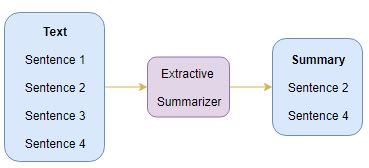


*   The most relevant **sentences are extracted and concatenated** to get the summary
*   The summary is usually **not fluent**
*   The extraction can be formulated as a **binary classification problem** (by predicting whether a sentence should be included in the summary) or extracting the **most scored sentences** based on syntactic and semantic relationships




<a name='1.2'></a>
### 1.2 - Abstractive Summarization

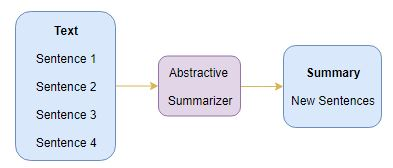



*   Generation of **new sentences** providing the document's most relevant information

*   **Human-like** process

*   The summary is usually **fluent** but may contain **hallucinations**!

*   **More challenging** task


<a name='2'></a>
## 👨‍💻 2 - Understand How Language Models Work

Install dependencies...



In [ ]:
!pip install datasets==2.14.6
!pip install transformers[torch]==4.38.1
!pip install accelerate==0.27.2
!pip install bitsandbytes==0.42.0
!pip install evaluate==0.4.0
!pip install bert_score==0.3.12
!pip install rouge_score
!pip install nltk

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.
torch 2.5.

Set a seed for reproducibility: we want to allow everyone to reproduce the experiments with the same results.

In [ ]:
from transformers import set_seed

set_seed(42)

<a name='2.1'></a>
### 2.1 - Load the Model

In [ ]:
from accelerate import Accelerator
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


model_checkpoint = "facebook/bart-large"

# We need it to leverage fp16 (mixed precision) computation to save memory and accelerate the training.
accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=1)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(accelerator.device)

# We leverage the gradient checkpointing to save memory.
model.gradient_checkpointing_enable()
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional t

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

<a name='2.2'></a>
### 2.2 - What's the input like?

In [ ]:
import nltk
nltk.download('punkt')

colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]

def show_tokens(sentence, tokenizer):
    """
    Show highlighted tokens and input lengths.
    """
    token_ids = tokenizer(sentence).input_ids
    for idx, t in enumerate(token_ids):
        print(
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            tokenizer.decode(t) +
            '\x1b[0m',
            end=' '
        )
    print("\n")
    print(token_ids)
    print(f"\n\nNumber of words: {len(nltk.word_tokenize(sentence))}\nNumber of tokens: {len(token_ids)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
input_text = "How do large language models work?"

show_tokens(input_text, tokenizer)

<s> How  do  large  language  models  work ? </s> 

[0, 6179, 109, 739, 2777, 3092, 173, 116, 2]


Number of words: 7
Number of tokens: 9


In [ ]:
input_text = "Look at this tokenization segmentation"

show_tokens(input_text, tokenizer)

<s> Look  at  this  token ization  segment ation </s> 

[0, 15833, 23, 42, 19233, 1938, 2835, 1258, 2]


Number of words: 5
Number of tokens: 9


<a name='2.3'></a>
### 2.3 - What About the Output?

In [ ]:
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)

In [ ]:
input_ids

tensor([[    0, 15833,    23,    42, 19233,  1938,  2835,  1258,     2]],
       device='cuda:0')

In [ ]:
# Prediction scores for each vocabulary token before SoftMax.
logits = model(input_ids).logits
print(logits)
print(logits.shape)

tensor([[[ 17.0868,  -0.8329,  16.6723,  ...,  -0.5525,  -1.5189,   6.6934],
         [ 17.0868,  -0.8329,  16.6723,  ...,  -0.5525,  -1.5189,   6.6934],
         [-25.4707,  -4.0715,   8.3299,  ...,  -0.3954,  -1.2762,   7.2108],
         ...,
         [-15.4399,  -3.7799,  10.7467,  ...,  -4.2490,  -4.2524,  -1.3792],
         [-13.3796,  -4.1631,  11.0278,  ...,  -3.8814,  -3.3312,  -2.4492],
         [-13.5723,  -3.6931,  17.5395,  ...,  -3.6665,  -3.1530,  -2.6529]]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 9, 50265])


In [ ]:
output_ids = model.generate(
    input_ids=input_ids,
    max_length=50,
)
print(output_ids)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


tensor([[    2,     0, 15833,    23,    42, 19233,  1938,  2835,  1258,     2]],
       device='cuda:0')


In [ ]:
output = tokenizer.batch_decode(output_ids, skip_special_tokens=False)[0]
print(output)

</s><s>Look at this tokenization segmentation</s>


LLMs often struggle with basic arithmetic, but not for the reasons one might initially assume. The issue stems from how numbers are tokenized, which is optimized for language efficiency rather than mathematical operations.

In most LLM tokenizers, including GPT-2's:
1. Single-token number representation:
   - The integers 0-9 don't each get their own unique token.
   - Instead, many multi-digit numbers are assigned single tokens.

2. Frequency-based tokenization - the image below shows the integers from 1 to 10k, with 100 per row. <mark>If a square is colored yellow it means a unique token is assigned to that integer and if it is purple then the integer is coded by a composite set of tokens</mark> in the GPT-2 tokenizer:
   - The first 512 integers each get a unique token.
   - Years between 1930 and 2019 also receive individual tokens.
   - This is due to their frequent occurrence in training data.

3. Inconsistent number representation:
   - Some numbers are represented by single tokens.
   - Others are broken into multiple tokens.
   - This lack of consistency complicates arithmetic processing.

4. Mathematical vs. linguistic optimization:
   - The tokenization is optimized for language modeling efficiency.
   - It's not designed with mathematical operations in mind.

5. Computational challenge:
   - Before performing calculations, the LLM must deconstruct these linguistically-optimized number representations.
   - This extra step introduces complexity and potential for error.



<img src="https://media.licdn.com/dms/image/v2/D4D22AQHSvid4S7Tznw/feedshare-shrink_800/feedshare-shrink_800/0/1727853729032?e=1730937600&v=beta&t=3uiOc9kLZ9O7vAOLJEvc4VMyloQMfjlveH4V2IyFj_Y" alt="Tokenizing Digits">

<br><br>

LLMs are terrible at spelling, too.

<img src="https://global.discourse-cdn.com/openai1/optimized/4X/5/c/0/5c0d5882b9651fab40a71246423bdd0f9781b0e6_2_509x499.jpeg" alt="Strawbarry problem">

<br><br>

> What about different languages?!

Have a look at [this Linkedin post](https://www.linkedin.com/feed/update/urn:li:activity:7247143812853059584/) for more references

<a name='3'></a>
## 👨‍💻 3 - Evaluate Generated Summaries with ROUGE

**ROUGE** stands for Recall-Oriented Understudy for Gisting Evaluation.

ROUGE is the leading evaluation metric for text summarization that compares a model-generated summary against the reference human-annotated one. It works by matching the **n-grams overlaps** of the generated and gold summary. Several metrics are available:

* **ROUGE-1** refers to the **overlap of uni-grams** (each word) between the generated and reference summaries.

* **ROUGE-2** refers to the **overlap of bi-grams**  (pairs of words) between the generated and reference summaries.

* **ROUGE-L** identifies the longest n-grams co-occurring in the two sequences (**Longest Common Subsequence**).

The scores range from 0 to 1 (we report the %, i.e., between 0 and 100; the higher, the better).

<a name='3.1'></a>
### 3.1 - Understand ROUGE with an Example

In [ ]:
from datasets import load_metric


rouge = load_metric("rouge")

def get_rouge_scores(predictions, references):
    """
    Compute and return the ROUGE metrics (R1, R2, RL, each with precision, recall, f1 scores).
    """
    rouge_output = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    return {
        "r1-p": round(rouge_output["rouge1"].mid.precision * 100, 2),
        "r1-r": round(rouge_output["rouge1"].mid.recall * 100, 2),
        "r1-f1": round(rouge_output["rouge1"].mid.fmeasure * 100, 2),
        "r2-p": round(rouge_output["rouge2"].mid.precision * 100, 2),
        "r2-r": round(rouge_output["rouge2"].mid.recall * 100, 2),
        "r2-f1": round(rouge_output["rouge2"].mid.fmeasure * 100, 2),
        "rL-p": round(rouge_output["rougeL"].mid.precision * 100, 2),
        "rL-r": round(rouge_output["rougeL"].mid.recall * 100, 2),
        "rL-f1": round(rouge_output["rougeL"].mid.fmeasure * 100, 2)
    }

<ipython-input-13-3b19ab4eed8d>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


In [ ]:
predictions = ["I absolutely loved reading the Hunger Games"]
references = ["i loved reading the Hunger Games."]

scores = get_rouge_scores(predictions=predictions, references=references)

print(f'rouge-1:\t P:{scores["r1-p"]} \t R:{scores["r1-r"]} \t F1:{scores["r1-f1"]}')
print(f'rouge-2:\t P:{scores["r2-p"]} \t R:{scores["r2-r"]} \t F1:{scores["r2-f1"]}')
print(f'rouge-L:\t P:{scores["rL-p"]} \t R:{scores["rL-r"]} \t F1:{scores["rL-f1"]}')

rouge-1:	 P:85.71 	 R:100.0 	 F1:92.31
rouge-2:	 P:66.67 	 R:80.0 	 F1:72.73
rouge-L:	 P:85.71 	 R:100.0 	 F1:92.31


**Note**: ROUGE is case-insensitive ("I" and "i" are the same) and does not consider punctuactions ("." in the reference).

For ROUGE, "recall" (R) measures how much of the reference summary is captured by the generated one (i.e., *how many words of the reference are within the prediction?*). If we are just comparing words, "recall" can be calculated according to the following formula:

$$Recall = \frac{\text{Number of overlapping words}}{\text{Total number of words in reference summary}}$$

For our simple example above, this formula gives a perfect recall of 6/6 = 1; i.e., *all the words in the reference summary have been produced by the model*.

This may sound great, but imagine if our generated summary had been "I really really loved reading the Hunger Games all night." This would also have perfect recall, but is arguably a worse summary since it is verbose. To deal with these scenarios, we also compute the "precision", which in the ROUGE context measures how much of the generated summary was relevant (i.e., *how many words of the prediction are within the reference?*):

$$Precision = \frac{\text{Number of overlapping words}}{\text{Total number of words in generated summary}}$$

Applying this to our verbose summary gives a "precision" of 6/10 = 0.6, which is considerably worse than the "precision" of 6/7 = 0.86 obtained by our shorter one (in the cell above). In practice, both "precision" and "recall" are usually computed, and then the "F1-score" (i.e., the harmonic mean of "precision" and "recall") is reported:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

<a name='3.2'></a>
### 3.2 - What are the Limitations?

1. The sentences are semantically the same (i.e., they have the same meaning), but ROUGE evaluates only the syntactic aspect.

In [ ]:
references = ["a big man is sad"]
predictions = ["the huge guy was not happy"]

scores = get_rouge_scores(predictions=predictions, references=references)

print(f'rouge-1:\t P:{scores["r1-p"]} \t R:{scores["r1-r"]} \t F1:{scores["r1-f1"]}')
print(f'rouge-2:\t P:{scores["r2-p"]} \t R:{scores["r2-r"]} \t F1:{scores["r2-f1"]}')
print(f'rouge-L:\t P:{scores["rL-p"]} \t R:{scores["rL-r"]} \t F1:{scores["rL-f1"]}')

rouge-1:	 P:0.0 	 R:0.0 	 F1:0.0
rouge-2:	 P:0.0 	 R:0.0 	 F1:0.0
rouge-L:	 P:0.0 	 R:0.0 	 F1:0.0


2. The sentences have the same words, but ROUGE-2 and ROUGE-L consider the word position.

In [ ]:
references = ["a big man is sad"]
predictions = ["is sad a big man"]

scores = get_rouge_scores(predictions=predictions, references=references)

print(f'rouge-1:\t P:{scores["r1-p"]} \t R:{scores["r1-r"]} \t F1:{scores["r1-f1"]}')
print(f'rouge-2:\t P:{scores["r2-p"]} \t R:{scores["r2-r"]} \t F1:{scores["r2-f1"]}')
print(f'rouge-L:\t P:{scores["rL-p"]} \t R:{scores["rL-r"]} \t F1:{scores["rL-f1"]}')

rouge-1:	 P:100.0 	 R:100.0 	 F1:100.0
rouge-2:	 P:75.0 	 R:75.0 	 F1:75.0
rouge-L:	 P:60.0 	 R:60.0 	 F1:60.0


3. The sentences have opposite meaning, but ROUGE does not fully capture this.

In [ ]:
references = ["a big man born in New York is sad"]
predictions = ["a big man born in New York is not sad"]

scores = get_rouge_scores(predictions=predictions, references=references)

print(f'rouge-1:\t P:{scores["r1-p"]} \t R:{scores["r1-r"]} \t F1:{scores["r1-f1"]}')
print(f'rouge-2:\t P:{scores["r2-p"]} \t R:{scores["r2-r"]} \t F1:{scores["r2-f1"]}')
print(f'rouge-L:\t P:{scores["rL-p"]} \t R:{scores["rL-r"]} \t F1:{scores["rL-f1"]}')

rouge-1:	 P:90.0 	 R:100.0 	 F1:94.74
rouge-2:	 P:77.78 	 R:87.5 	 F1:82.35
rouge-L:	 P:90.0 	 R:100.0 	 F1:94.74


<a name='3.3'></a>
### 3.3 - The Evaluate Library

We report the correct approach to compute the ROUGE scores (despite it does not provide precision and recall scores).

The output is the following dictionary:

{'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum'
}

The "sum" in "rougeLsum" refers to the fact that this metric is computed over a whole summary, while "rougeL" is computed as the average over individual sentences.

**Note:** since in our examples there is only one sentence for both the reference and prediction, "rougeL" and "rougeLsum" will be the same.

In [ ]:
!pip install nltk

In [ ]:
import evaluate
import nltk

rouge = evaluate.load("rouge")

In [ ]:
def postprocess_text(predictions, references):
    """
    Preprocess the text before computing ROUGE.
    """
    preds = [pred.strip() for pred in predictions]
    labels = [label.strip() for label in references]
    # rougeLsum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]
    return preds, labels


def get_rouge_scores(predictions, references):
    """
    Compute and return the ROUGE scores.
    """
    predictions, references = postprocess_text(predictions, references)
    result_rouge = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    result = {k: round(v * 100, 2) for k, v in result_rouge.items()}
    return result

In [ ]:
references = ["a big man born in New York is sad"]
predictions = ["a big man born in New York is not sad"]

scores = get_rouge_scores(predictions, references)
scores

{'rouge1': 94.74, 'rouge2': 82.35, 'rougeL': 94.74, 'rougeLsum': 94.74}

<a name='4'></a>
## 👨‍💻 4 - Explore Dataset Loading with HuggingFace

<a name='4.1'></a>
### 4.1 - XSUM

We explore [XSum](https://huggingface.co/datasets/EdinburghNLP/xsum), one of the most known datasets for Text Summarization. It contains over 200K BBC articles with the corresponding manually labeled one-sentence summary.

Download the dataset...



In [ ]:
from datasets import load_dataset

xsum = load_dataset("EdinburghNLP/xsum")

print(xsum)

xsum_train = xsum["train"] # need it to train models how to summarize the documents
xsum_eval = xsum["validation"] # need it to track model performance during training to avoid overfitting
xsum_test = xsum["test"] # need it to evaluate model performance once the model is already trained

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})


In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML


def show_random_samples(dataset, num_examples=3):
    """
    Show random samples from a dataset.
    """
    assert num_examples <= len(dataset), "Can't pick more samples than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset) - 1)
        while pick in picks:
            pick = random.randint(0, len(dataset) - 1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_samples(xsum_train)

,document,summary,id
0,"Private Harry Vasey, who was part of the 1st Airborne Battalion, The Border Regiment, was killed during Operation Market Garden in Oosterbeek in 1944.\nNow his identity has been confirmed, the Ministry of Defence (MoD) want to trace his family so his grave can be rededicated in the Netherlands.\nThe MoD said plans were also in place to change his headstone.\nBorn in Durham in May 1916 to Harry Vasey and Annie Young, he enlisted in April 1940 when he lived in Bowburn, County Durham.\nAn MoD spokesman said: ""Unfortunately that is about all we know about Private Vasey and his family and that's where the trail goes cold.\n""We are hoping that there are some of his family still living in that area.""\nSince WW2, a section of the Royal Netherlands Army has been working to identify the graves of unknown soldiers killed in battle.\nThe exhumation reports were scrutinised for clues to the identities of these men and the research was presented to the MoD.\nMr Vasey is one of six Border Regiment soldiers, including Lance Corporal Raymond Halliday, to be indentified.\nThe aim of Operation Market Garden was to take strategic bridges near Arnhem, but the Allies underestimated the number of German troops lying in wait and it failed.\nMore than 1,400 Allied troops died and more than 6,000 were captured by German forces.\nIt is hoped Mr Vasey's surviving relatives can attend the service at Oosterbeek Cemetery on 14 September in honour of his sacrifice and bravery, the MoD said.",The family of a soldier killed during World War Two is being sought after his final resting place was confirmed.,36802710
1,"Hooker Richard Hibbard and prop John Afoa return as David Humphreys makes 10 changes to the team which beat the French side 35-14 on 8 December.\nLewis Ludlow, Jacob Rowan and Ben Morgan also start in the pack, while Callum Braley starts at scrum-half.\nJames Hook takes David Halaifonua's spot at full-back, with Jonny May and Charlie Sharples on the wings.\nStade Rochelais: Murimurivalu; Lacroix, Jordaan, Aguillon, Rattez; James, Bales; Corbel, Forbes, Atonio, Qovu, Tanguy, Sazy, Eaton (capt.), Vito.\nReplacements: Maurouard, Priso, Boughanmi, Cedaro, Francoz, Retiere, Holmes, Botia.\nGloucester: Hook; Sharples, Scott, Atkinson, May; Burns, Braley (capt.); Hohneck, Hibbard, Afoa, Savage, Thrush, Ludlow, Rowan, Morgan.\nReplacements: Matu'u, Thomas, Doran-Jonesm Latta, Galarza, Heinz, Purdy, Kvesic.\nFor the latest rugby union news follow @bbcrugbyunion on Twitter.",Gloucester lock Jeremy Thrush will make his first appearance of the season against Stade Rochelais.,38307773
2,"The university announced back in March it needed to save £10.5m and planned to cut 150 posts.\nMembers of the University and College Union (UCU) Scotland were balloted as a result.\nAfter the ballot closed on Monday, the union said 73% of those who voted backed strike action. And 80% also voted for action short of a strike.\nAndrew MacKillop, Aberdeen UCU representative, said: ""Members have made it quite clear that they reject the job losses proposed by the university.\n""Strike action is always a last resort but we can't sit back and see jobs lost with the accompanying damage to the student experience and the reputation of the university.""\nIn a statement, the university said it was disappointed that the union had vote for strike action ""in the midst of ongoing dialogue"".\nIt added: ""According to the results of the ballot, 263 UCU members voted in favour of strike action, representing 12.5% of our total academic and academic-related workforce.\n""The UCU had asked for assurance that the university would rule out compulsory redundancies as it seeks to make savings of £10.5m.\n""We were unable to give that assurance, although we are working tirelessly to achieve the savings we need through voluntary measures as far as possible, and are pursuing a range of additional options to increase our efficiency as a world-leading university.""",Staff at the 

<a name='4.2'></a>
### 4.2 - Exercises ✏️

Try it out!

1. Calculate the average number of words (using "nltk.word_tokenize") and tokens (using BART's tokenizer) in the documents and summaries of XSUM. **Note:** we want these statistics on the entire dataset (without considering the splits).
2. Re-calculate these statistics per split to verify if the splits are balanced in document statistics.
3. Which is the average document compression? (*Compression is the ratio between the number of source words and the number of target words*).

In [ ]:
## TODO

<a name='5'></a>
## 👨‍💻 5 - News Summarization with BART

In this part of the notebook, you will fine-tune a generative language model from HuggingFace for news document summarization.
You will use the [BART](https://huggingface.co/docs/transformers/model_doc/bart) model, which is an encoder-decoder transformer trained using masked language modeling (MLM) as unsupervised training objective, where tokens are masked and the model has learned to predict them (**denoising objective**).

![](https://miro.medium.com/max/1400/1*xYqyt4Gzl1SAioip9NdaXQ.png)

To improve the inferences, you will explore a fine-tuning approach and evaluate the results with ROUGE metrics.

<a name='5.1'></a>
### 5.1 - Define Hyperparameters

It is possible to pull out the number of model parameters and find out how many of them are trainable.

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 406291456
all model parameters: 406291456
percentage of trainable model parameters: 100.00%


In [ ]:
# The max input size that BART can process (it is limited to max 1024 tokens).
max_source_length = 1024

# The max output size that BART must generate (it depends on the average
# summary size of the dataset under cosideration).
min_target_length = 10
max_target_length = 64

# The penalty ensures that no n-gram (3-grams here) appears twice by manually setting
# the probability of the following words that could create an already seen n-gram to 0.
no_repeat_ngram_size = 3

# The number of instances processed by models at each step.
# Note: the larger the batch size, the larger the GPU memory required.
batch_size = 2

<a name='5.2'></a>
### 5.2 - Zero-Shot Inference
Zero-shot inference (in this context) refers to prompting the model with the input instances without any fine-tuning to align the model with the target task.

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm


def test(model, tokenizer, dataset, accelerator, text_column, summary_column, max_source_length, min_target_length,
         max_target_length, stop_ngrams, epoch, is_eval, has_glob_attn=False, is_primera=False):
    """
    Generate summaries from a list of documents.
    """
    if is_eval and epoch is not None:
        print("***** Running validation *****")
        print(f"Epoch: {epoch + 1}/{num_epochs}")
    else:
        print(f"***** Running test *****")
    print(f"Num examples = {len(dataset)}")

    # We need it to create the batches from data.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    if is_eval:
        dataloader = accelerator.prepare(dataloader)  # It is required for using the training acceleration.

    progress_bar = tqdm(range(len(dataloader)))  # A handy progress bar.

    predictions = []
    model.eval()  # We set the model in the evaluation status (no dropout layers are applied).

    for step, batch in enumerate(dataloader):
        with torch.no_grad():  # Of course, no training happens here.

            document = batch[text_column]  # Get the document (with batch_size=2, we have a list of 2 documents).

            # Tokenize the input (will be a pytorch tensor).
            # Truncate the inputs longer than max_length (1024 here).
            # Pad shorter sequences to 1024 tokens if shorter.
            input_dict = tokenizer(document, return_tensors="pt", truncation=True,
                                   padding=True, max_length=max_source_length)

            # Input ids: the sequence of tokens.
            input_ids = input_dict["input_ids"].to(model.device)

            # Attention mask: let models understand which are the token to process or to ignore (pad tokens).
            # In practice: it put a 0 if the token is a pad token, 0 otherwise.
            attention_mask = input_dict["attention_mask"].to(model.device)

            if is_eval:
                model = accelerator.unwrap_model(model)


            # Only for models with linear attention (e.g., LED and PRIMERA).
            if has_glob_attn:
                # Global tokens attend to all other tokens (quadratic self-attention).
                # For text summarization, only the first token (<s>) ha s gloabl attention.
                global_attention_mask = torch.zeros_like(attention_mask)
                global_attention_mask[:, 0] = 1
                # Only for PRIMERA.
                if is_primera:
                    global_attention_mask[input_ids == tokenizer.convert_tokens_to_ids("<doc-sep>")] = 1

                output_model = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    global_attention_mask=global_attention_mask,
                    max_length=max_target_length,
                    min_length=min_target_length,
                    early_stopping=True,
                    num_beams=2,
                    length_penalty=1.0,
                    repetition_penalty=1.0,
                    no_repeat_ngram_size=stop_ngrams,
                )
            else:
                output_model = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=max_target_length,
                    min_length=min_target_length,
                    early_stopping=True,
                    num_beams=2,
                    length_penalty=1.0,
                    repetition_penalty=1.0,
                    no_repeat_ngram_size=stop_ngrams,
                )

            # Decode the output tokens to obtain the textual summary.
            prediction = tokenizer.batch_decode(output_model, skip_special_tokens=True)
            predictions.extend(prediction)

            progress_bar.update(1)

    return predictions

Based on the dataset, we take the name of the input and target columns.

In [ ]:
text_column = "document"
summary_column = "summary"

To save time, we use just the first 10 samples of the test set.

In [ ]:
max_test_samples = 10

test_dataset = xsum_test.select(range(min(len(xsum_test), max_test_samples)))

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
predictions_zeroshot = test(
    model, tokenizer, test_dataset, accelerator, text_column, summary_column, max_source_length,
    min_target_length, max_target_length, no_repeat_ngram_size, epoch=None, is_eval=False
)

rouge_scores = get_rouge_scores(predictions=predictions_zeroshot, references=test_dataset[summary_column])

print(f"\n\nROUGE-1: {rouge_scores['rouge1']}\nROUGE-2: {rouge_scores['rouge2']}\nROUGE-L: {rouge_scores['rougeL']}")

***** Running test *****
Num examples = 10


100%|██████████| 5/5 [00:22<00:00,  4.52s/it]




ROUGE-1: 19.64
ROUGE-2: 2.74
ROUGE-L: 11.26


Let's print a predicted summary along its human-annotated one.

In [ ]:
dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'HUMAN SUMMARY:\n{xsum_test[summary_column][0]}')
print(dash_line)
print(f'MODEL SUMMARY:\n{predictions_zeroshot[0]}')
print(dash_line)

---------------------------------------------------------------------------------------------------
HUMAN SUMMARY:
There is a "chronic" need for more housing for prison leavers in Wales, according to a charity.
---------------------------------------------------------------------------------------------------
MODEL SUMMARY:
The Welsh Government said more people than ever were getting help to address housing problems.The charity which helps ex-offenders find accommodation after their release from prison, Prison Link Cymru, said the number of people living on the streets in Wales has risen by more than a third in the past
---------------------------------------------------------------------------------------------------


<a name='5.3'></a>
### 5.3 - Few-Shot Learning
We will test now the effect that a few training steps have on the model's performance.

In [ ]:
import math
from transformers import get_scheduler


def train(model, tokenizer, train_dataset, eval_dataset, accelerator, text_column, summary_column, max_source_length,
          min_target_length, max_target_length, stop_ngrams, has_glob_attn=False, is_primera=False):
    """
    Train the model on text summarization.
    """
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    gradient_accumulation_steps = 1
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    max_train_steps = num_epochs * num_update_steps_per_epoch

    optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5)

    num_warmup_steps = math.ceil(max_train_steps / 10) * gradient_accumulation_steps

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps * gradient_accumulation_steps,
        num_training_steps=max_train_steps * gradient_accumulation_steps,
    )

    model, optimizer, lr_scheduler, train_dataloader = accelerator.prepare(
        model, optimizer, lr_scheduler, train_dataloader
    )

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    max_train_steps = num_epochs * num_update_steps_per_epoch
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    total_batch_size = batch_size * gradient_accumulation_steps

    progress_bar = tqdm(range(max_train_steps))
    best_rouge_scores = 0

    print("\n***** Running training *****")
    print(f"Num examples = {len(train_dataset)}")
    print(f"Num epochs = {num_epochs}")
    print(f"Total train batch size = {total_batch_size}")
    print(f"Gradient accumulation steps = {gradient_accumulation_steps}")
    print(f"Total optimization steps = {max_train_steps}\n")

    for epoch in range(num_train_epochs):
        model.train()  # Set the model in the training status (activate dropout layers).

        for step, batch in enumerate(train_dataloader):

            document = batch[text_column]
            summary = batch[summary_column]

            input_dict = tokenizer(document, return_tensors="pt", truncation=True, padding=True,
                                       max_length=max_source_length)
            input_ids = input_dict["input_ids"].to(model.device)
            attention_mask = input_dict["attention_mask"].to(model.device)

            output_dict = tokenizer(summary, return_tensors="pt", truncation=True, padding=True,
                                    max_length=max_target_length)

            labels = output_dict["input_ids"].to(model.device)
            # Set the pad token to -100 (required to compute the loss).
            labels = labels.where(labels != tokenizer.pad_token_id,
                                  torch.tensor(-100, device=model.device))
            decoder_attention_mask = output_dict["attention_mask"].to(model.device)

            global_attention_mask = None

            # Only for LED and PRIMERA models.
            if has_glob_attn:
                global_attention_mask = torch.zeros_like(attention_mask)
                global_attention_mask[:, 0] = 1
                # Only for PRIMERA.
                if is_primera:
                    global_attention_mask[input_ids == tokenizer.convert_tokens_to_ids("<doc-sep>")] = 1

            with accelerator.accumulate(model):
                if global_attention_mask is None:
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask
                    )
                else:
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        global_attention_mask=global_attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask
                    )
                loss = outputs.loss  # Get the loss (is a tensor).

                accelerator.backward(loss)  # Backpropagation.
                optimizer.step()  # Update the optimizer.
                lr_scheduler.step()  # Update the scheduler of the learning rate.
                optimizer.zero_grad()  # Clear the gradients.

            if accelerator.sync_gradients:
                # Print the loss in the progress bar.
                progress_bar.set_postfix_str(f"Loss: {str(loss.item())}")
                progress_bar.update(1)

**Exercise**: Validation phase!
 1. Test the model performance on the validation set.
 2. Compute ROUGE scores and get the average score ([R1 + R2 + RL] / 3).
 3. If the average score is greater than the score of the previous epoch, then save the model.

In [ ]:
## TODO

To save time, as we did for the test set, we select only the first 100 and 10 instances for the training and validation sets, respectively.  

In [ ]:
max_train_samples = 100  # It is a real-world low-resource scenario.
train_dataset = xsum_train.select(range(min(len(xsum_train), max_train_samples)))

# The number of times that the model processes the training data.
num_epochs = 5

max_eval_samples = 10
eval_dataset = xsum_eval.select(range(min(len(xsum_eval), max_eval_samples)))

Start training process...



In [ ]:
train(
    model, tokenizer, train_dataset, eval_dataset, accelerator, text_column, summary_column,
    max_source_length, min_target_length, max_target_length, no_repeat_ngram_size
)

  0%|          | 0/250 [00:00<?, ?it/s]


***** Running training *****
Num examples = 100
Num epochs = 5
Total train batch size = 2
Gradient accumulation steps = 1
Total optimization steps = 250



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
100%|██████████| 250/250 [01:44<00:00,  2.40it/s, Loss: 0.35705429315567017]


Let's generate the predictions.

In [ ]:
predictions_fewshot = test(
    model, tokenizer, test_dataset, accelerator, text_column, summary_column, max_source_length,
    min_target_length, max_target_length, no_repeat_ngram_size, epoch=None, is_eval=False
)

***** Running test *****
Num examples = 10


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Let's calculate the summaries' quality with ROUGE.

In [ ]:
rouge_scores = get_rouge_scores(predictions=predictions_fewshot, references=test_dataset[summary_column])

print(rouge_scores)

{'rouge1': 31.53, 'rouge2': 10.19, 'rougeL': 25.34, 'rougeLsum': 24.96}


In [ ]:
idx = 0

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'HUMAN SUMMARY:\n{xsum_test[summary_column][idx]}')
print(dash_line)
print(f'0-SHOT MODEL SUMMARY:\n{predictions_zeroshot[idx]}')
print(dash_line)
print(f'FEW-SHOT MODEL SUMMARY:\n{predictions_fewshot[idx]}')
print(dash_line)

---------------------------------------------------------------------------------------------------
HUMAN SUMMARY:
There is a "chronic" need for more housing for prison leavers in Wales, according to a charity.
---------------------------------------------------------------------------------------------------
0-SHOT MODEL SUMMARY:
The Welsh Government said more people than ever were getting help to address housing problems.The charity which helps ex-offenders find accommodation after their release from prison, Prison Link Cymru, said the number of people living on the streets in Wales has risen by more than a third in the past
---------------------------------------------------------------------------------------------------
FEW-SHOT MODEL SUMMARY:
Welsh prison leavers are struggling to find suitable accommodation after leaving prison, a charity says.
---------------------------------------------------------------------------------------------------


> What do you notice? Do the summaries have the right content or the right style?

<a name='5.4'></a>
### 5.4 - Full Fine-Tuning
What if we train on the whole dataset? To save time let's download a model from HuggingFace already trained on this dataset.

In [ ]:
from accelerate import Accelerator
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


model_checkpoint = "facebook/bart-large-xsum"

# We need it to leverage fp16 (mixed precision) computation to save memory and accelerate the training.
accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=1)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(accelerator.device)

# We leverage the gradient checkpointing to save memory.
model.gradient_checkpointing_enable()
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

In [ ]:
predictions_finetuned = test(
    model, tokenizer, test_dataset, accelerator, text_column, summary_column, max_source_length,
    min_target_length, max_target_length, no_repeat_ngram_size, epoch=None, is_eval=False
)

***** Running test *****
Num examples = 10


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


In [ ]:
rouge_scores = get_rouge_scores(predictions=predictions_finetuned, references=test_dataset[summary_column])

print(rouge_scores)

{'rouge1': 39.25, 'rouge2': 13.75, 'rougeL': 28.47, 'rougeLsum': 28.48}


In [ ]:
idx = 0

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'HUMAN SUMMARY:\n{xsum_test[summary_column][idx]}')
print(dash_line)
print(f'0-SHOT MODEL SUMMARY:\n{predictions_zeroshot[idx]}')
print(dash_line)
print(f'FEW-SHOT MODEL SUMMARY:\n{predictions_fewshot[idx]}')
print(dash_line)
print(f'FINETUNED MODEL SUMMARY:\n{predictions_finetuned[idx]}')
print(dash_line)

---------------------------------------------------------------------------------------------------
HUMAN SUMMARY:
There is a "chronic" need for more housing for prison leavers in Wales, according to a charity.
---------------------------------------------------------------------------------------------------
0-SHOT MODEL SUMMARY:
The Welsh Government said more people than ever were getting help to address housing problems.The charity which helps ex-offenders find accommodation after their release from prison, Prison Link Cymru, said the number of people living on the streets in Wales has risen by more than a third in the past
---------------------------------------------------------------------------------------------------
FEW-SHOT MODEL SUMMARY:
Welsh prison leavers are struggling to find suitable accommodation after leaving prison, a charity says.
---------------------------------------------------------------------------------------------------
FINETUNED MODEL SUMMARY:
More needs 

<a name='6'></a>
## 👨‍💻 6 - Legal Case Summarization

In this second case study, we will explore the long document summarization task, showing the limitations that quadratic models (such as BART) have. The input is a long legal document with its corresponding summary.

> Linear, Quadratic .. what’s the deal with these? Hang on, we will see them at the right moment!

In [ ]:
from datasets import load_dataset

govreport = load_dataset("ccdv/govreport-summarization")

print(govreport)

govreport_train = govreport["train"]
govreport_eval = govreport["validation"]
govreport_test = govreport["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/17517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/973 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/973 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['report', 'summary'],
        num_rows: 17517
    })
    validation: Dataset({
        features: ['report', 'summary'],
        num_rows: 973
    })
    test: Dataset({
        features: ['report', 'summary'],
        num_rows: 973
    })
})


In [ ]:
show_random_samples(govreport_train)

In [ ]:
text_column = "report"
summary_column = "summary"

In [ ]:
max_test_samples = 10

test_dataset = govreport_test.select(range(min(len(govreport_test), max_test_samples)))

In [ ]:
num_words_source = [len(nltk.word_tokenize(x)) for x in test_dataset[text_column]]
num_words_target = [len(nltk.word_tokenize(x)) for x in test_dataset[summary_column]]

print(f"Num of words in the source -> MIN:{min(num_words_source)}\tAVG: {sum(num_words_source)/len(num_words_source)}\tMAX: {max(num_words_source)}")
print(f"Num of words in the target -> MIN:{min(num_words_target)}\tAVG: {sum(num_words_target)/len(num_words_target)}\tMAX: {max(num_words_target)}")

Num of words in the source -> MIN:2536	AVG: 9944.2	MAX: 14882
Num of words in the target -> MIN:544	AVG: 689.8	MAX: 1111


<a name='6.1'></a>
### 👨‍💻 6.1 - BART

In [ ]:
from accelerate import Accelerator
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


model_checkpoint = "twigs/facebook-bart-large-1024-govreport"

# We need it to leverage fp16 (mixed precision) computation to save memory and accelerate the training.
accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=1)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(accelerator.device)

# We leverage the gradient checkpointing to save memory.
model.gradient_checkpointing_enable()
model.config.use_cache = False

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/813M [00:00<?, ?B/s]

In [ ]:
max_source_length = 1024
min_target_length = 10
max_target_length = 256

no_repeat_ngram_size = 5

Start inference...



In [ ]:
predictions_bart = test(
    model, tokenizer, test_dataset, accelerator, text_column, summary_column, max_source_length,
    min_target_length, max_target_length, no_repeat_ngram_size, epoch=None, is_eval=False
)

***** Running test *****
Num examples = 10


100%|██████████| 5/5 [02:47<00:00, 33.41s/it]


In [ ]:
rouge_scores_bart = get_rouge_scores(predictions=predictions_bart, references=test_dataset[summary_column])

print(rouge_scores_bart)

{'rouge1': 3.47, 'rouge2': 0.0, 'rougeL': 2.77, 'rougeLsum': 3.29}


<a name='6.2'></a>
### 👨‍💻 6.2 - LED

**LED** (Longformer-Encoder-Decoder) is an encoder-decoder transformer that differs from BART because of its attention mechanism, which scales linearly in the input size. Thus, this model belongs to the family of linear (efficient) transformers.
For the sake of time, we load an already full finetuned LED model on GovReport.

In [ ]:
checkpoint = "Xmm/led-large-16384-govreport"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(accelerator.device)
model.gradient_checkpointing_enable()
model.config.use_cache = False

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:472: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configura

generation_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

In [ ]:
# Actually, LED can process up to 16384 tokens, but for memory limitations, we set 4096 tokens as the max input size.
max_source_length = 4096
min_target_length = 10
max_target_length = 512

no_repeat_ngram_size = 5

In [ ]:
predictions_led = test(
    model, tokenizer, test_dataset, accelerator, text_column, summary_column, max_source_length,
    min_target_length, max_target_length, no_repeat_ngram_size, epoch=None, is_eval=False, has_glob_attn=True
)

rouge_scores_led = get_rouge_scores(predictions=predictions_led, references=test_dataset[summary_column])

print(rouge_scores_led)

***** Running test *****
Num examples = 10


100%|██████████| 5/5 [00:31<00:00,  6.25s/it]


{'rouge1': 54.51, 'rouge2': 21.9, 'rougeL': 23.37, 'rougeLsum': 51.51}


<a name='7'></a>
## 👨‍💻 7 - Summarize Dialogue with Prompt Engineering

In this part of the lab you will do the dialogue summarization task using generative AI. You will explore **how the input text affects the output of the model**, and perform **prompt engineering** to direct it towards the task you need. By comparing zero shot, one shot, and few shot inferences, you will take the first step towards prompt engineering and see how it can enhance the generative output of Large Language Models.

Now install the required packages to use PyTorch and Hugging Face transformers and datasets.



In [ ]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 50.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.13.1 which is incompatible.
torchvision 0.19.1+cu121 requi

Load the datasets, Large Language Model (LLM), tokenizer, and configurator. Do not worry if you do not understand yet all of those components - they will be described and discussed later in the notebook.

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

<a name='7.1'></a>
### 7.1 - Dataset and Model Loading

In this use case, you will be generating a summary of a dialogue with the pre-trained Large Language Model (LLM) FLAN-T5 from Hugging Face. The list of available models in the Hugging Face `transformers` package can be found [here](https://huggingface.co/docs/transformers/index).

Let's upload some simple dialogues from the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. This dataset contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  else:


Generating validation split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  else:


Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  else:


Print a couple of dialogues with their baseline summaries.

In [ ]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT DIALOGUE:')
    print(dataset['test'][index]['dialogue'])
    print(dash_line)
    print('BASELINE HUMAN SUMMARY:')
    print(dataset['test'][index]['summary'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT DIALOGUE:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------
Exa

For the experiments in the following sections we will use the `Flan-T5-base` model. The [T5 (Text-To-Text Transfer Transformer)](https://arxiv.org/abs/1910.10683) model was finetuned by pre-pending short, task-specific instructions to the input data instances. **This allowed the model to treat a wide variety of NLP tasks uniformly, simply by formatting each task as a text transformation problem**. For example, a summarization task could be framed as: _"summarize: [input text]"_, while a translation task might start with _"translate English to French: [input text]"_.

**By adding these task prompts, T5 learned to generalize across different NLP tasks with minimal structural changes**, making the model both flexible and efficient in adapting to new tasks through transfer learning.


<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*CgIp9Y5-6lLdKDrocKQaCQ.png" alt="T5 Fine-Tuning" width="800"/>
</p>


You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).



Load the [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5), creating an instance of the `AutoModelForSeq2SeqLM` class with the `.from_pretrained()` method.

In [ ]:
model_name='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Download the tokenizer for the FLAN-T5 model using `AutoTokenizer.from_pretrained()` method. Parameter `use_fast` switches on fast tokenizer. At this stage, there is no need to go into the details of that, but you can find the tokenizer parameters in the [documentation](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoTokenizer).

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Test the tokenizer encoding and decoding a simple sentence:

In [ ]:
sentence = "What time is it, Tom?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0],
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

ENCODED SENTENCE:
tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])

DECODED SENTENCE:
What time is it, Tom?


<a name='7.2'></a>
### 7.2 - Summarize Dialogue without Prompt Engineering

Now it's time to explore how well the base LLM summarizes a dialogue without any prompt engineering. **Prompt engineering** is an act of a human changing the **prompt** (input) to improve the response for a given task.

In [ ]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    inputs = tokenizer(dialogue, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{dialogue}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - WITHOUT PROMPT ENGINEERING:
Person1: It's ten to nine.

-------------------------------

You can see that the guesses of the model make some sense, but it doesn't seem to be sure what task it is supposed to accomplish. Seems it just makes up the next sentence in the dialogue. Prompt engineering can help here.

<a name='7.3'></a>
### 7.3 - Summarize Dialogue with an Instruction Prompt

Prompt engineering is an important concept in using foundation models for text generation.

<a name='7.3.1'></a>
#### 7.3.1 - Zero Shot Inference with an Instruction Prompt

In order to instruct the model to perform a task - summarize a dialogue - you can take the dialogue and convert it into an instruction prompt. This is often called **zero shot inference**.

Wrap the dialogue in a descriptive instruction and see how the generated text will change:

In [ ]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Summarize the following conversation in an informative way.

{dialogue}

TL;DR:
    """

    # Input constructed prompt instead of the dialogue.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation in an informative way.

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

TL;DR:
    
---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.
---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
T

This is much better! But the model still does not pick up on the nuance of the conversations though.

**Exercise:**

- Experiment with the `prompt` text and see how the inferences will be changed. Will the inferences change if you end the prompt with just empty string vs. `Summary: `?
- Try to rephrase the beginning of the `prompt` text from `Summarize the following conversation.` to something different - and see how it will influence the generated output.

In [ ]:
## TODO

<a name='7.3.2'></a>
#### 7.3.2 - Zero Shot Inference with the Prompt Template from FLAN-T5

Let's use a slightly different prompt. FLAN-T5 has many prompt templates that are published for certain tasks [here](https://github.com/google-research/FLAN/tree/main/flan/v2). In the following code, you will use one of the [pre-built FLAN-T5 prompts](https://github.com/google-research/FLAN/blob/main/flan/v2/templates.py):

In [ ]:
for i, index in enumerate(example_indices):
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    prompt = f"""
Dialogue:

{dialogue}

What was going on?
"""

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
Tom is late for the train.

--------------

Notice that this prompt from FLAN-T5 did help a bit, but still struggles to pick up on the nuance of the conversation. This is what you will try to solve with the few shot inferencing.

<a name='7.4'></a>
### 7.4 - Summarize Dialogue with One Shot and Few Shot Inference

**One shot and few shot inference** are the practices of providing an LLM with either one or more full examples of prompt-response pairs that match your task - before your actual prompt that you want completed. This is called "in-context learning" and puts your model into a state that understands your specific task.  You can read more about it in [this blog from HuggingFace](https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api).

<a name='7.4.1'></a>
#### 7.4.1 - One Shot Inference

Let's build a function that takes a list of `example_indices_full`, generates a prompt with full examples, then at the end appends the prompt which you want the model to complete (`example_index_to_summarize`).  You will use the same FLAN-T5 prompt template from Section [7.2](#7.2).

In [ ]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']

        # The stop sequence '{summary}\n\n\n' is important for FLAN-T5. Other models may have their own preferred stop sequence.
        prompt += f"""
Dialogue:

{dialogue}

What was going on?
{summary}


"""

    dialogue = dataset['test'][example_index_to_summarize]['dialogue']

    prompt += f"""
Dialogue:

{dialogue}

What was going on?
"""

    return prompt

Construct the prompt to perform one shot inference:

In [ ]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also ne

Now pass this prompt to perform the one shot inference:

In [ ]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to add a CD-ROM drive.


<a name='7.4.2'></a>
#### 7.4.2 - Few Shot Inference

Let's explore few shot inference by adding two more full dialogue-summary pairs to your prompt.

In [ ]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Dialogue:

#Person1#: What time is it, Tom?
#Person2#: Just a minute. It's ten to nine by my watch.
#Person1#: Is it? I had no idea it was so late. I must be off now.
#Person2#: What's the hurry?
#Person1#: I must catch the nine-thirty train.
#Person2#: You've plenty of time yet. The railway station is very close. It won't take more than twenty minutes to get there.

What was going on?
#Person1# is in a hurry to catch a train. Tom tells #Person1# there is plenty of time.



Dialogue:

#Person1#: May, do you mind helping me prepare for the picnic?
#Person2#: Sure. Have you checked the weather report?
#Person1#: Yes. It says it will be sunny all day. No sign of rain at all. This is your father's favorite sausage. Sandwiches for you and Daniel.
#Person2#: No, thanks Mom. I'd like some toast and chicken wings.
#Person1#: Okay. Please take some fruit salad and crackers for me.
#Person2#: Done. Oh, don't forget to take napkins disposable plates, cups and picnic blanket.
#Person1#: All set. 

Now pass this prompt to perform a few shot inference:

In [ ]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.

---------------------------------------------------------------------------------------------------
MODEL GENERATION - FEW SHOT:
#Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.


<a name='8'></a>
## 👨‍💻 8 - Summarize Dialogue with Parameter Efficient Fine-tuning

In this part of the notebook, you will fine-tune an existing LLM from Hugging Face for enhanced dialogue summarization. As before, you will use the [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model, which provides a high quality instruction tuned model and can summarize text out of the box. To improve the inferences, you will explore a full fine-tuning approach and evaluate the results with ROUGE metrics. Then you will perform **Parameter Efficient Fine-Tuning (PEFT)** and evaluate the resulting model.

Now install the required packages for the LLM and datasets.



In [ ]:
%pip install --upgrade pip
%pip install gdown
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==3.0.1 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

> RESTART THE ENVIRONMENT

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

Load the pre-trained base version of [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5) and its tokenizer directly from HuggingFace. Setting `torch_dtype=torch.bfloat16` specifies the memory type to be used by this model.

In [ ]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name,
                                                       torch_dtype=torch.bfloat16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name,use_fast=True)

It is possible to pull out the number of model parameters and find out how many of them are trainable. The following function can be used to do that, at this stage, you do not need to go into details of it.

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


<a name='8.1'></a>
### 8.1 - Preprocess the Dialogue-Summary Dataset

You are going to continue experimenting with the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.




In [ ]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Let's load the dataset.

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

To save some time in the lab, you will subsample the dataset:

In [ ]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Check the shapes of all three parts of the dataset:

In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
})


The output dataset is ready for fine-tuning.

### 8.2 Full Fine-tuning of Small LLMs

<a name='8.2.1'></a>
#### 8.2.1 - Fine-tune the Model with the Pre-processed Dataset

Now utilize the built-in Hugging Face `Trainer` class (see the documentation [here](https://huggingface.co/docs/transformers/main_classes/trainer)). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

Let's set the training hyperparameters. You can tweak them to affect the effectiveness of the training

In [ ]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY=1e-2]

BATCH_SIZE = 4

NUM_TRAIN_EPOCHS = 1

# let's keep the training iteration low for the sake of fast experiments during the lab
MAX_STEPS = 10

In [ ]:
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    logging_steps=1,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=BATCH_SIZE
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

Start training process...



In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,50.250000
2,49.500000
3,50.750000
4,49.500000
5,53.250000
6,51.000000
7,46.250000
8,51.000000
9,49.500000
10,47.750000


TrainOutput(global_step=10, training_loss=49.875, metrics={'train_runtime': 17.4104, 'train_samples_per_second': 2.297, 'train_steps_per_second': 0.574, 'total_flos': 27390294097920.0, 'train_loss': 49.875, 'epoch': 0.31})

Training a fully fine-tuned version of the model would take a few hours on a GPU. To save time, download a checkpoint of the fully fine-tuned model to use in the rest of this notebook. This fully fine-tuned model will also be referred to as the **instruct model** in this lab.

In [ ]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("disi-unibo-nlp/flan-T5-dialogsum",
                                                       torch_dtype=torch.bfloat16).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

<a name='8.2.2'></a>
#### 8.2.2 - Model Evaluation
Let's now evaluate the model performances before and after fine-tuning.


##### 8.2.2.1 Human Evaluation

As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1: Have you considered upgrading your system?
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# upgrading #Person2#'s system, hardware, and CD-ROM drive. #Person2# thinks it's great.


<a name='8.2.2.2'></a>
##### 8.2.2.2 - ROUGE Evaluation

We can now use a precise automatic metric like ROUGE.

In [ ]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,The following memo is a memo to all employees ...,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,Employees will be notified by the Office of Ma...,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,Employees are required to have their own dicta...,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,#Person2: I'm sorry to hear that.,#Person2# got stuck in traffic again. #Person1...
4,#Person2# decides to follow #Person1#'s sugges...,"The weather is fine, but the traffic is bad.",#Person2# got stuck in traffic again. #Person1...
5,#Person2# complains to #Person1# about the tra...,: I'm sorry I got stuck in traffic again.,#Person2# got stuck in traffic again. #Person1...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are divorced.,Masha and Hero are getting divorced. Kate can'...
9,#Person1# and Brian are at the birthday party ...,"#Person1: Happy birthday, Brian. #Person2: I'm...",Brian's birthday is coming. #Person1# invites ...


Evaluate the models computing ROUGE metrics. Notice the improvement in the results!

In [ ]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2216675981945467, 'rouge2': 0.08985072637611624, 'rougeL': 0.20385662894503465, 'rougeLsum': 0.20739180046527356}
INSTRUCT MODEL:
{'rouge1': 0.41026607717457186, 'rouge2': 0.17840645241958838, 'rougeL': 0.2977022096267017, 'rougeLsum': 0.2987374187518165}


The file `dialogue-summary-training-results.csv` contains a pre-populated list of all model results which you can use to evaluate on a larger section of data. Let's do that for each of the models:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!gdown --id 1UIJckFttxgj81EhqZlQGXUv5-dcoD7vy

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UIJckFttxgj81EhqZlQGXUv5-dcoD7vy
To: /content/dialogue-summary-training-results.csv
100% 883k/883k [00:00<00:00, 9.47MB/s]


In [ ]:
results = pd.read_csv("dialogue-summary-training-results.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}


The results show substantial improvement in all ROUGE metrics:

In [ ]:
print("Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over HUMAN BASELINE
rouge1: 18.82%
rouge2: 10.43%
rougeL: 13.70%
rougeLsum: 13.69%


<a name='8.3'></a>
### 8.3 - Parameter Efficient Fine-Tuning with LoRA

Now, let's perform **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning" as you did above.

**PEFT** is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon. PEFT is a generic term indicating a family of techniques. It includes **Low-Rank Adaptation (LoRA)** and prompt tuning (<u>which is NOT THE SAME as prompt engineering!</u>).








<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1w5BoyVcpkYrXcD_2vczTcQBC8cwTXico" alt="LoRA on Attention Layers" width="1200"/>
</p>

> From ["Evaluating Parameter-Efficient Transfer Learning Approaches on SURE Benchmark for Speech Understanding"](https://arxiv.org/abs/2303.03267).

[**LoRA**](https://arxiv.org/abs/2106.09685) fine-tunes models by **introducing additional low-rank matrices into specific layers** of a pre-trained language model. Instead of updating the entire weight matrix during training, **LoRA injects two small trainable matrices that approximate the weight updates**, while the original weights remain frozen. This setup effectively learns task-specific information through these low-rank updates, while maintaining the integrity of the pre-trained model.

</br>

These lower rank matrices--called **adapters**--flank the pre-trained weight matrices $W$ and lay on their embedded knwoledge for the new domain adaptaion:
$$
\mathbf{W} \in \mathbb{R}^{d \times d} \approx \mathbb{R}^{d \times r} \ni \mathbf{W_A \times W_B} \in \mathbb{R}^{r \times d}
$$
with $r$ being the **rank** which regulates the reduction in number of trainable parameters while preserving the original input and output shapes.

<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rOW5plKBuMlGgpD0SO8nZA.png" alt="T5 Fine-Tuning" width="900"/>
</p>


The core idea behind LoRA is **decomposing the weight updates into smaller components**, allowing efficient task-specific adaptation without needing to modify the entire model. This approach significantly reduces the number of parameters that need to be trained.


> You will see this and other efficient training techniques more in details during the course. **Hang on!**





In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, **allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU)**. After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. **This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs)**.  

</br>

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request. The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

> If you’re wondering whether your memory is sufficient for fine-tuning a model, check it out [here](https://huggingface.co/spaces/Vokturz/can-it-run-llm).

<a name='8.3.1'></a>
#### 8.3.1 - Train the Adapters

You need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

</br>

Adapters can be applied wherever desired, however it is good practice to apply them to linear layers for stability reasons during fine-tuning and to avoid phenomena such as *catastrophic forgetting*. In our experiments we will target the **query** and **value** projection matrices in the attention layers throughout the whole archtecture.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType


RANK = 32             # regulates adapters dimension
LORA_ALPHA = 32       # scaling factors for the intialization of adapters
LORA_DROPOUT = 0.05   # dropout factor for the LoRA layers

TARGET_LAYERS = ["q", "v"]

lora_config = LoraConfig(
    r=RANK,
    lora_alpha=LORA_ALPHA,
    target_modules=TARGET_LAYERS,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # define the model's architecture
)

Add LoRA adapter layers/parameters to the original LLM to be trained.

In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


😧 <u>We are just training **1.4%** of the total parameters!!</u>

Define training arguments and create `Trainer` instance.

In [ ]:
LEARNING_RATE = 1e-3 # Higher learning rate than full fine-tuning.

BATCH_SIZE = 4
NUM_TRAIN_EPOCHS = 1
MAX_STEPS = 10

In [ ]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    logging_steps=1,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=BATCH_SIZE
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

Now everything is ready to train the PEFT adapter and save the model.



In [ ]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,49.000000
2,47.000000
3,44.250000
4,39.500000
5,38.750000
6,32.750000
7,31.375000
8,29.875000
9,29.125000
10,28.625000


('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/spiece.model',
 './peft-dialogue-summary-checkpoint-local/added_tokens.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

That training was performed on a subset of data. To load a fully trained PEFT model, read a checkpoint of a PEFT model from our HuggingFace repository.

Prepare this model by adding an adapter to the original FLAN-T5 model. You are setting `is_trainable=False` because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set `is_trainable=True`.

In [ ]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       'disi-unibo-nlp/flan-T5-base-dialogsum-adapters',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

You can see here the T5 model structure augmented with adapters.

In [ ]:
peft_model

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

The number of trainable parameters will be `0` due to `is_trainable=False` setting:

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 0 || all params: 251116800 || trainable%: 0.0


<a name='8.3.2'></a>
#### 8.3.2 - Model Evaluation

<a name='8.3.2.1'></a>
##### 8.3.2.1 - Human Evaluation

Make inferences for the same example as in Section [8.2.2.1](#8.2.2.1), with the original model, fully fine-tuned and PEFT model.

In [ ]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
You're going to be upgrading your computer system.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
#Person1# suggests #Person2# upgrading #Person2#'s system, hardware, and CD-ROM drive. #Person2# thinks it's great.
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person1# recommends adding a painting program to #Person2#'s software and upgrading hardware. #Person2# also wants to upgrade the hardware because it's outdated now.


<a name='8.3.2.2'></a>
##### 8.3.2.2 - ROUGE Evaluation

Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time).

In [ ]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    human_baseline_text_output = human_baseline_summaries[idx]

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,The Office of the President and CEO is requiri...,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
1,In order to prevent employees from wasting tim...,The following memo is to be distributed to all...,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
2,Ms. Dawson takes a dictation for #Person1# abo...,This is an intra-office memo.,#Person1# asks Ms. Dawson to take a dictation ...,#Person1# asks Ms. Dawson to take a dictation ...
3,#Person2# arrives late because of traffic jam....,The person is a commuter.,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
4,#Person2# decides to follow #Person1#'s sugges...,I'm finally here. I'm stuck in traffic. I'm st...,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
5,#Person2# complains to #Person1# about the tra...,You're finally here.,#Person2# got stuck in traffic again. #Person1...,#Person2# got stuck in traffic and #Person1# s...
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced. Kate can'...,Kate tells #Person2# Masha and Hero are gettin...
9,#Person1# and Brian are at the birthday party ...,Brian's birthday is today.,Brian's birthday is coming. #Person1# invites ...,Brian remembers his birthday and invites #Pers...


Compute ROUGE score for this subset of the data.

In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2251650450998277, 'rouge2': 0.08266666666666667, 'rougeL': 0.19062610497393107, 'rougeLsum': 0.19391456369717236}
INSTRUCT MODEL:
{'rouge1': 0.41026607717457186, 'rouge2': 0.17840645241958838, 'rougeL': 0.2977022096267017, 'rougeLsum': 0.2987374187518165}
PEFT MODEL:
{'rouge1': 0.3725351062275605, 'rouge2': 0.12138811933618107, 'rougeL': 0.27620639623170606, 'rougeLsum': 0.2758134870822362}


> Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the `data/dialogue-summary-training-results.csv` file. Load the values for the PEFT model now and check its performance compared to other models.

In [ ]:
human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values
peft_model_summaries     = results['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}
PEFT MODEL:
{'rouge1': 0.40810631575616746, 'rouge2': 0.1633255794568712, 'rougeL': 0.32507074586565354, 'rougeLsum': 0.3248950182867091}


The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE
rouge1: 17.47%
rouge2: 8.73%
rougeL: 12.36%
rougeLsum: 12.34%


Now calculate the improvement of PEFT over a full fine-tuned model:

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -1.35%
rouge2: -1.70%
rougeL: -1.34%
rougeLsum: -1.35%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).

<a name='8.4'></a>
### 8.4 - Finetuning big LLMs with Unsloth

In this section we will finetune a (very) Large Language Model <u>on Colab</u> with the amazing 🦥 **Unsloth** library. Thanks to an optimized memory management of the transformer's internal information, this library allows you to finetune models on small GPUs, reaching a x2 inference performance boost.

If you prefer, to avoid dealing with library version errors, you can now delete your current run-time and create a new one. Then install the following packages.



In [ ]:
%%capture
!pip install datasets
!pip install trl bitsandbytes
!pip install evaluate rouge_score
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

> RESTART THE ENVIRONMENT

In [ ]:
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from unsloth import FastLanguageModel

import torch
from datasets import load_dataset

from evaluate import load
from tqdm import tqdm

rouge = load("rouge")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


We also define a util function to perform parallel generation using batches. For our tests we shall use a simple and direct instruction prompt.

In [ ]:
SYSTEM_PROMPT = """You are a helpful assistant. Your task is to summarize the texts provided by the user.
Answer directly with no prehamble or comment.
Be precise and concise.
"""


def generate_outputs_in_batches(model,
                                tokenizer,
                                dataset,
                                batch_size : int = 16,
                                max_length : int = 512,
                                max_new_tokens : int = 256,
                                device : str = "cuda"):

    # Enable native 2x faster inference
    FastLanguageModel.for_inference(model)


    texts = dataset["dialogue"]

    # Calculate the number of batches
    num_batches = (len(texts) + batch_size - 1) // batch_size

    generated_outputs = []
    for i in tqdm(range(num_batches)):
        this_batch = texts[i * batch_size:(i + 1) * batch_size]

        # prompt the data into a conversation-like input
        batch_texts = []
        for txt in this_batch:
          msg = [
              {
                  "role" : "system",
                  "content" : SYSTEM_PROMPT
              },
              {
                  "role" : "user",
                  "content" : txt
              }
          ]
          msg_prompted = tokenizer.apply_chat_template(msg, tokenize=False, add_generation_prompt=True)
          batch_texts.append(msg_prompted)

        inputs = tokenizer(batch_texts,
                           padding=True,
                           return_tensors="pt",
                           max_length=max_length,
                           truncation=True).to(device)

        # Let's use greedy decoding
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.2,
            use_cache=True
        )

        # Decode the generated outputs into human-readable text
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # post-process outputs to remove special tokens
        parsed_dec_outs = []
        for out in decoded_outputs:
          parsed_dec_outs.append(out.split("assistant")[-1].strip())

        generated_outputs.extend(parsed_dec_outs)

    return generated_outputs

<a name="Train"></a>
#### 8.4.1 Load Dataset and Model

Let's download (again) the `dialogsum` dataset and format it.

In [ ]:
from datasets import load_dataset
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

Now we can load the model. We will use `Llama-3.1-8B-Instruct` from Meta.

**Why using and fine-tuning an Instruct model?**

Instruct models, which undergo instruction tuning phases, offer distinct advantages for specific tasks. While base models, if fine-tuned, can lead to better results due to their greater flexibility, <mark>instruction-tuned models excel at following instructions out of the box</mark>. This makes them particularly suitable for controllable tasks like controllable summarization, where precise adherence to guidelines is crucial.

For short training sessions focused on formatting writing styles rather than injecting new knowledge, using an instruction-tuned model can be the optimal choice.

In [ ]:
MAX_SEQ_LENGTH = 2048     # You can choose any value thanks to interal RoPE scaling
dtype = None              # None for auto detection
load_in_4bit = True       # Use 4bit quantization to reduce memory usage

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct",
    max_seq_length = MAX_SEQ_LENGTH,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

Instruction-tuned models are fine-tuned to follow a specific input template that clearly define the system prompt, the user query and the model's answer. This is particularly useful for conversatioanl agents to define the roles in the chat history.

Also for "one-shot" instruction dialogues, we must follow such formalism to elicit the model's capabilities and fully exploit its potentialities.

In [ ]:
msgs = [
    {
        "role" : "system",
        "content" : "You are a helpful assistant. Your task is to answer the user's questions precisely."
    },
    {
        "role" : "user",
        "content" : "If a brick weights 1 kilo plus half a kilo, how much does a brick weigh?"
    },
    {
        "role" : "assistant",
        "assistant" : "eh, nice question. Gpt-4o doesn't know, how am I supposed to?!"
    }
]

chat_msgs = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=False)
print(chat_msgs)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant. Your task is to answer the user's questions precisely.<|eot_id|><|start_header_id|>user<|end_header_id|>

If a brick weights 1 kilo plus half a kilo, how much does a brick weigh?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

<|eot_id|>


Roles are delimited by some special tags. <mark>Each instruction-tuned LLM has its owns</mark>.

We (obviously) don’t have the model’s answer for open generation, so we need to leave the assistant field out of the input. However, we must remember to append the assistant tag at the end so that the model can begin generating correctly starting from there.

In [ ]:
msgs = [
    {
        "role" : "system",
        "content" : "You are a helpful assistant. Your task is to answer the user's questions precisely."
    },
    {
        "role" : "user",
        "content" : "If a brick weights 1 kilo plus half a kilo, how much does a brick weigh?"
    },
]
chat_msgs = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
print(chat_msgs)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant. Your task is to answer the user's questions precisely.<|eot_id|><|start_header_id|>user<|end_header_id|>

If a brick weights 1 kilo plus half a kilo, how much does a brick weigh?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




Let's now evaluate the performances of the base model on a small test sample.

In [ ]:
test_dataset = dataset["test"].select(range(100))

In [ ]:
gen_configs = {
    "model" : model,
    "tokenizer" : tokenizer,
    "dataset" : test_dataset,
    "batch_size" : 8,
    "max_new_tokens" : 64
}

original_model_summaries = generate_outputs_in_batches(**gen_configs)

In [ ]:
reference_txt = test_dataset["dialogue"][10]
print(reference_txt)

#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday


In [ ]:
print(original_model_summaries[10])
print("-"*50)
print(test_dataset["summary"][10])

Person 1 (Brian) is celebrating Person 2's birthday and is invited to join the party. Person 1 asks Person 2 to dance and they both enjoy the party. Person 2 compliments Person 1 on their appearance, and Person 1 thanks them.
--------------------------------------------------
#Person1# attends Brian's birthday party. Brian thinks #Person1# looks great and charming.


In [ ]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=test_dataset["summary"],
    use_aggregator=True,
    use_stemmer=True,
)
print(f"ORIGINAL MODEL STATS:")
print(original_model_results)

ORIGINAL MODEL STATS:
{'rouge1': 0.2470848016290792, 'rouge2': 0.06981056388687591, 'rougeL': 0.19009708377139617, 'rougeLsum': 0.19015514960200877}


Results show how LLMs have already optimal performances in zero-shot contexts. However, without proper prompt tuning to align the model, generations may be “too good”. LLMs are fine-tuned to satisfy users in terms of clarity and exhaustiveness. These features may, though, interfere with the dataset's style requirements. The take-home message is:
> LLMs are no magic potion! We have to learn how to deal with them.


The **goal of the training** is not teaching the model to acquire the ability to formulate summaries but rather to **align it to a specif format**.

We can now set the training configurations for LoRA.

In [ ]:
# >> Training arguments
SEED = 42

# > LoRA
R = 16
ALPHA = 16
LORA_DROPOUT = 0

# Train all linear layers in the attention modules
TARGET_LAYERS = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

# > Training
LR = 2e-4
TRAIN_BS=2
EVAL_BS=4
GRAD_ACC_STEPS=4
WARMUP_STEPS=5
WEIGHT_DECAY=0.01

MAX_STEPS=50

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = R,
    target_modules = TARGET_LAYERS,
    lora_alpha = ALPHA,
    lora_dropout = LORA_DROPOUT, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # for efficiency in gradient backpropagation (uses 30% less VRAM, fits 2x larger batch sizes)
    random_state = SEED,
    use_rslora = False,  # enable rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


We shall use the `SFTTrainer`, which requires combining input and labels in a unique prompt. For this purpose, we flatten data instances by merging the original text and the target summary using a simple prompt.

In [ ]:
from datasets import DatasetDict

def flatten_data(example : dict) -> str:
    """
    Combine and prompt data instances by merging the original text and the target summary using a simple prompt.
    """
    msg = [
        {
            "role" : "system",
            "content" : "You are a helpful assistant. Your task is to summarize the texts provided by the user."
        },
        {
            "role" : "user",
            "content" : example["dialogue"]
        },
        {
            "role" : "assistant",
            "content" : example["summary"]
        }
    ]
    out = {"text" : tokenizer.apply_chat_template(msg, tokenize=False, add_generation_prompt=False)}
    return out

cols = dataset.column_names

flatten_ds = DatasetDict({
    split : dataset[split].map(flatten_data, remove_columns=cols[split])
    for split in dataset
})

flatten_ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1500
    })
})

<a name="Train"></a>
#### 8.4.2 Unsloth Training

As we are not interested in fine-tuning the model on the whole text but on the target summary only, we can define a data construct that masks the input up to the start of the text to be generated.

In [ ]:
response_template = "assistant<|end_header_id|>\n\n"
collator = DataCollatorForCompletionOnlyLM(response_template,
                                           tokenizer=tokenizer)

In doing so, the model will only learn to generate a summary based on a query. This may seem counterintuitive, but sometimes we want to fine-tune the model using the entire input text. For example, training the model to predict the next token in the question based on the previous ones (this goes under the name of _Continual Pre-Training_).

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = flatten_ds["train"],
    eval_dataset = flatten_ds["validation"],
    dataset_text_field = "text",
    max_seq_length = MAX_SEQ_LENGTH,
    dataset_num_proc = 2,
    packing = False,
    data_collator=collator,
    args = TrainingArguments(
        per_device_train_batch_size = TRAIN_BS,
        per_device_eval_batch_size = EVAL_BS,
        gradient_accumulation_steps = GRAD_ACC_STEPS,
        warmup_steps = WARMUP_STEPS,
        max_steps = MAX_STEPS,
        learning_rate = LR,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = WEIGHT_DECAY,
        lr_scheduler_type = "linear",
        seed = SEED,
        output_dir = "outputs",
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 12,460 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 50
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.192500
2,2.228200
3,2.475900
4,1.871800
5,1.680200
6,1.399400
7,1.377700
8,1.217000
9,1.290500
10,0.777400


In [ ]:
trainer_stats

TrainOutput(global_step=50, training_loss=1.1007070291042327, metrics={'train_runtime': 427.5163, 'train_samples_per_second': 0.936, 'train_steps_per_second': 0.117, 'total_flos': 5768010617339904.0, 'train_loss': 1.1007070291042327, 'epoch': 0.03210272873194221})

For saving time, you can directly download the fine-tuned model from our Huggingface repository.

In [ ]:
#MAX_SEQ_LENGTH = 2048
#dtype = None
#
#model, tokenizer = FastLanguageModel.from_pretrained(
#    model_name = "disi-unibo-nlp/llama3-8B-Instrcut-adapters-dialogsum-lecture",
#    max_seq_length = MAX_SEQ_LENGTH,
#    dtype = dtype,
#    load_in_4bit = True,
#)

In [ ]:
gen_configs = {
    "model" : model,
    "tokenizer" : tokenizer,
    "dataset" : test_dataset,
    "batch_size" : 8,
    "max_new_tokens" : 50
}

instruct_model_summaries = generate_outputs_in_batches(**gen_configs)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=test_dataset["summary"],
    use_aggregator=True,
    use_stemmer=True,
)
print(f"INSTRUCT MODEL STATS:")
print(instruct_model_results)

100%|██████████| 13/13 [02:19<00:00, 10.72s/it]


INSTRUCT MODEL STATS:
{'rouge1': 0.4434875664255254, 'rouge2': 0.19104618420594055, 'rougeL': 0.381788311954771, 'rougeLsum': 0.38251384695744994}


In [ ]:
ID = 20

print(instruct_model_summaries[ID])
print("-"*50)
print(test_dataset["summary"][ID])

Person 2 has symptoms of itching, lightheadedness, and weakness, which may be caused by a rash or an allergy. Person 1 thinks it's chicken pox, which is contagious and potentially serious, especially for adults.
--------------------------------------------------
#Person1# thinks #Person2# has chicken pox and warns #Person2# about the possible hazards but #Person2# thinks it will be fine.


In [ ]:
ID = 20

print(instruct_model_summaries[ID])
print("-"*50)
print(test_dataset["summary"][ID])

#Person1# thinks #Person2# has chicken pox and #Person2# is contagious.
--------------------------------------------------
#Person1# thinks #Person2# has chicken pox and warns #Person2# about the possible hazards but #Person2# thinks it will be fine.


Notice how a short fine-tuning with little data and low computational resources can significantly impact the model's performance.

**Exercise**: compare the performance and outpus of a fine-tuned base model

You can find here [disi-unibo-nlp/llama3-8B-dialogsum-lecture](https://huggingface.co/disi-unibo-nlp/llama3-8B-dialogsum-lecture) a llama base model finetuned on summarization using the dialogsum dataset.

Try to run evaluation on this model --without using the chat template format-- to assess how base models behaves when given an instruction such as "summarize this text".


In [ ]:
## TODO

# 🏁 The End!